In [4]:
import numpy as np
import pylab as pb
import GPy

pb.ion()

In [5]:
# Edit this line to access a different backup file
backup_index = 99

X = np.load("hc_baby.npy", allow_pickle=True)
Y = np.log(np.load("samples_baby.npy", allow_pickle=True))

In [6]:
X_raw = np.load("hc_demo3.npy", allow_pickle=True)
Y_raw = np.log(np.load("samples_backup_i" + str(backup_index) + ".npy",
    allow_pickle=True))

 /tmp/ipykernel_83903/699833149.py:2: RuntimeWarning:divide by zero encountered in log


In [7]:
# We have to truncate the matrices a little because they use the shapes of the
# final products, meaning a lot of unfilled cells
X_truncated = X_raw[:backup_index]
Y_truncated = Y_raw[:backup_index]
# Possible off-by-one error here, but in this case that just means we're
# excluding one sample.

In [8]:
scale_factor = np.load("standard_k.npy", allow_pickle=True)

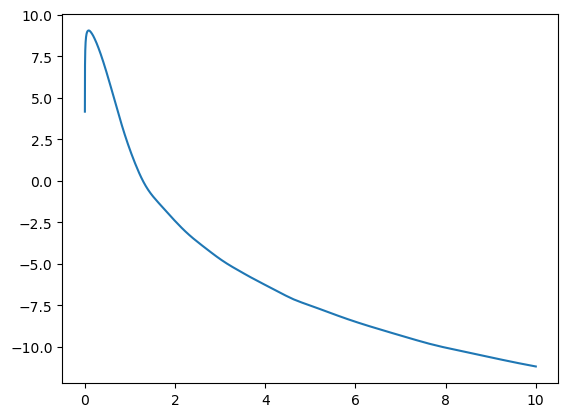

In [9]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.plot(scale_factor, Y_truncated[0])

In [10]:
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if float('-inf') in pspec:
        print("-inf")
    if float('inf') in pspec:
        print("inf")
    if None in pspec:
        print("None")
    if True in np.isnan(pspec):
        print("NaN in row", i)
        print(X_truncated[i])
    if 0 in pspec:
        print("zero")

In [11]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_truncated, bad_row_indices, 0)
Y = np.delete(Y_truncated, bad_row_indices, 0)

'''
# Now remove the offending rows
for i in reversed(bad_row_indices):
    # iterate backwards or else concurrent modification
    # makes the indices meaningless
    X.pop(i)
    Y.pop(i)
'''

'\n# Now remove the offending rows\nfor i in reversed(bad_row_indices):\n    # iterate backwards or else concurrent modification\n    # makes the indices meaningless\n    X.pop(i)\n    Y.pop(i)\n'

In [12]:
print(X.shape, Y.shape)

(99, 6) (99, 300)


In [13]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

In [14]:
m.constrain_positive('') # '' is a regex matching all parameter names
m.optimize()

In [15]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, 2.12723788013000E-09
])])
x

array([[2.24450000e-02, 1.20567000e-01, 9.60000000e-01, 8.24667740e-01,
        0.00000000e+00, 2.12723788e-09]])

In [16]:
guess, uncertainties = m.predict(x)

Text(0.5, 0, 'scale factor k')

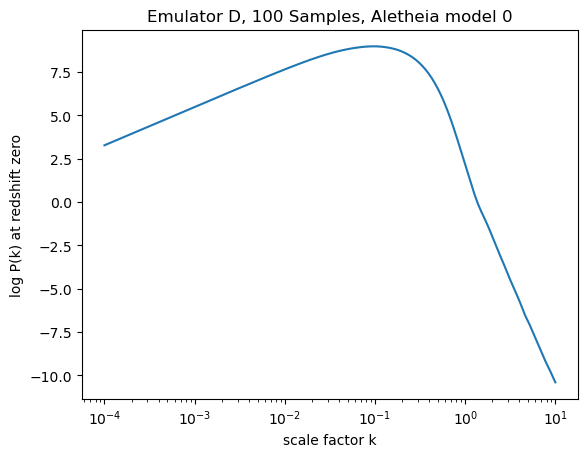

In [17]:
#import matplotlib.pyplot as plt
pb.plot(scale_factor, guess[0])
pb.title("Emulator D, 100 Samples, Aletheia model 0")
pb.xscale('log')
pb.ylabel('log P(k) at redshift zero')
pb.xlabel('scale factor k')

In [18]:
# Now let's check our work with battery
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

h = spectra.cosm.iloc[0]['h']

# Compare like to like
massless_cosmology = spectra.specify_neutrino_mass(spectra.cosm.iloc[0], 0, 0)
kh_m0truth, z_m0truth, ph_m0truth, s_m0truth = \
    spectra.kzps(massless_cosmology, zs=[0], k_points=300)
k_m0truth = kh_m0truth * h
p_m0truth = ph_m0truth / h ** 3
print(s_m0truth)

[0.82466774]


Next steps:
* Import "ground truth": what the plot was really supposed to look like for model 0
* Play with omega_nu, n_s, omega_nu + omega_cdm to see if you can get the same behavior as in the animations

Text(0.5, 0, 'scale factor k')

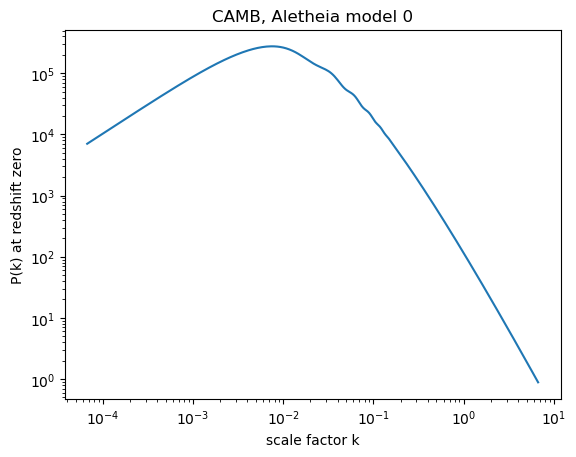

In [19]:
#import matplotlib.pyplot as plt
pb.loglog(k_m0truth, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale factor k')

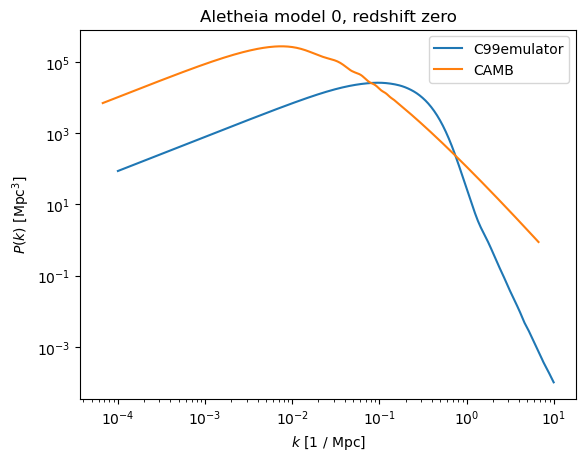

In [20]:
pb.plot(scale_factor, np.exp(guess[0]) / h**3, label="C" + str(backup_index) + "emulator")
pb.loglog(k_m0truth, p_m0truth, label="CAMB")
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('$k$ [1 / Mpc]')
pb.legend()

In [21]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.1, 0.82466774, 0, 2.12723788013000E-09
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.84, 0.82466774, 0, 2.12723788013000E-09
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(x_lo_ns)


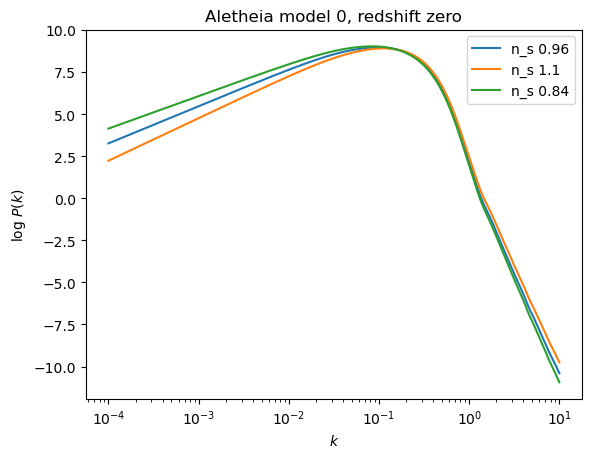

In [22]:
pb.plot(scale_factor, guess[0], label="n_s 0.96")
pb.plot(scale_factor, guess_hi_ns[0], label="n_s 1.1")
pb.plot(scale_factor, guess_lo_ns[0], label="n_s 0.84")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [23]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774, omnu_hi,\
    2.12723788013000E-09
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(x_hi_omnu)

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774, omnu_mid, \
    2.12723788013000E-09
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(x_mid_omnu)


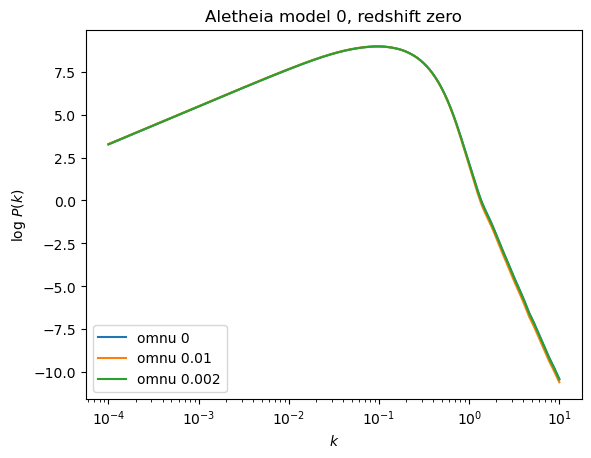

In [24]:
pb.plot(scale_factor, guess[0], label="omnu 0")
pb.plot(scale_factor, guess_hi_omnu[0], label="omnu 0.01")
pb.plot(scale_factor, guess_mid_omnu[0], label="omnu 0.002")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [25]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
hi_factor = 1.15
x_hi_omm = np.array([np.array([
    0.022445 * hi_factor, 0.120567 * hi_factor, 0.96, 0.82466774, 0,\
    2.12723788013000E-09
])])
guess_hi_omm, uncertainties_hi_omm = m.predict(x_hi_omm)

lo_factor = 0.85
x_lo_omm = np.array([np.array([
    0.022445 * lo_factor, 0.120567 * lo_factor, 0.96, 0.82466774, 0, \
    2.12723788013000E-09
])])
guess_lo_omm, uncertainties_lo_omm = m.predict(x_lo_omm)


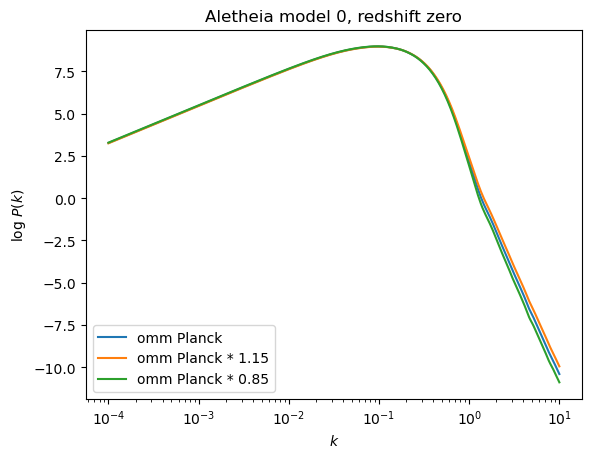

In [26]:
pb.plot(scale_factor, guess[0], label="omm Planck")
pb.plot(scale_factor, guess_hi_omm[0], label="omm Planck * 1.15")
pb.plot(scale_factor, guess_lo_omm[0], label="omm Planck * 0.85")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [27]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(3.91) / 10 ** 10
])])
guess_hi_As, uncertainties_hi_As = m.predict(x_hi_As)
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(2.35) / 10 ** 10 
])])
guess_lo_As, uncertainties_lo_As = m.predict(x_lo_As)

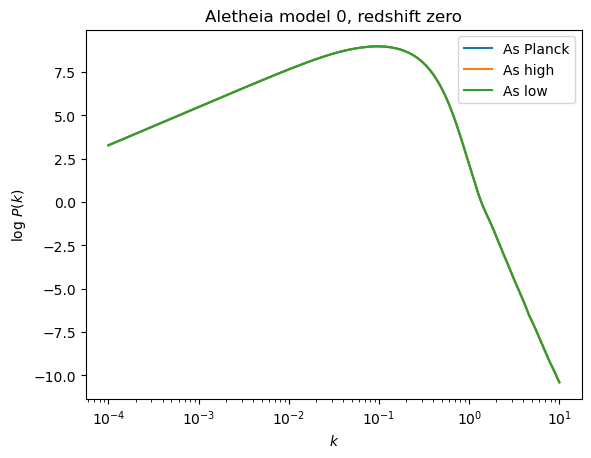

In [28]:
pb.plot(scale_factor, guess[0], label="As Planck")
pb.plot(scale_factor, guess_hi_As[0], label="As high")
pb.plot(scale_factor, guess_lo_As[0], label="As low")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

I guess this shows that sigma12 countermands As, huh?